In [1]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa import ar_model

In [3]:
# statusデータ
status = pd.read_csv('../../../status.csv')

In [4]:
#statusのyear, month, dayを結合してdatetime型に
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str) + '/' + status['hour'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'], format='%Y/%m/%d/%H', infer_datetime_format=True)
status.head()

,id,year,month,day,hour,station_id,bikes_available,predict,date
0,0,2013,9,1,0,0,11.0,0,2013-09-01 00:00:00
1,1,2013,9,1,1,0,11.0,0,2013-09-01 01:00:00
2,2,2013,9,1,2,0,11.0,0,2013-09-01 02:00:00
3,3,2013,9,1,3,0,11.0,0,2013-09-01 03:00:00
4,4,2013,9,1,4,0,11.0,0,2013-09-01 04:00:00


In [5]:
status_v0 = status[status['station_id'] == 0] 
status_v0 = status_v0[status_v0['date'] < '2013-09-10']
#status_v0 = status_v0.sort_values(status_v0['date'],ascending=True).reset_index(drop=True)

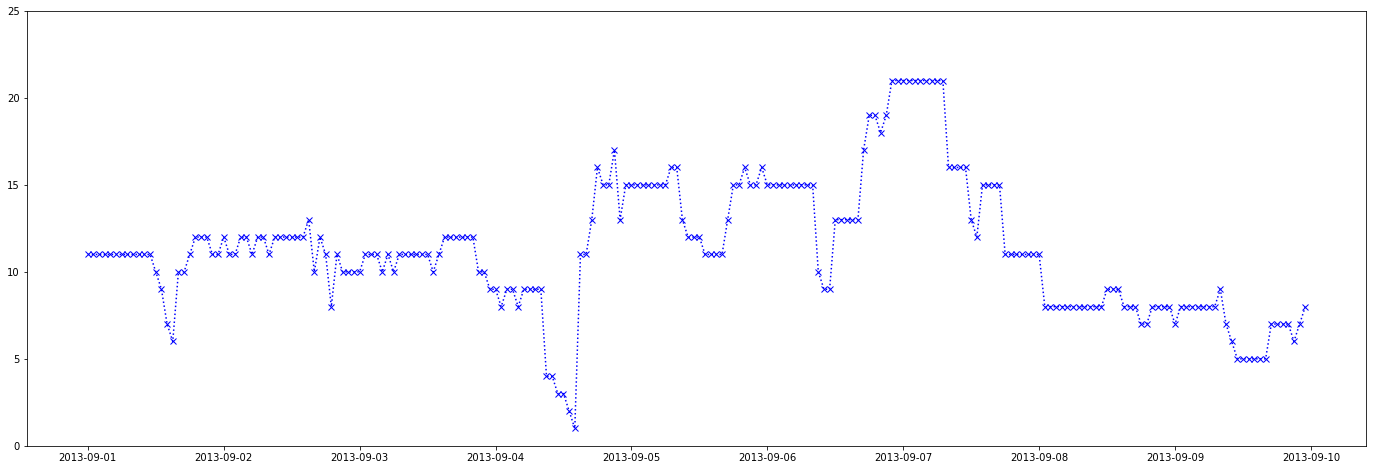

In [6]:
plt.figure(figsize=(24,8))
plt.ylim(0, 25)
plt.plot(status_v0['date'], status_v0['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')

In [7]:
status_v1 = status_v0.set_index('date')

In [8]:
status_v2 = status_v1['bikes_available']

In [9]:
status_v2

date
2013-09-01 00:00:00    11.0
2013-09-01 01:00:00    11.0
2013-09-01 02:00:00    11.0
2013-09-01 03:00:00    11.0
2013-09-01 04:00:00    11.0
                       ... 
2013-09-09 19:00:00     7.0
2013-09-09 20:00:00     7.0
2013-09-09 21:00:00     6.0
2013-09-09 22:00:00     7.0
2013-09-09 23:00:00     8.0
Name: bikes_available, Length: 216, dtype: float64

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#    rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=24).mean()
#    rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

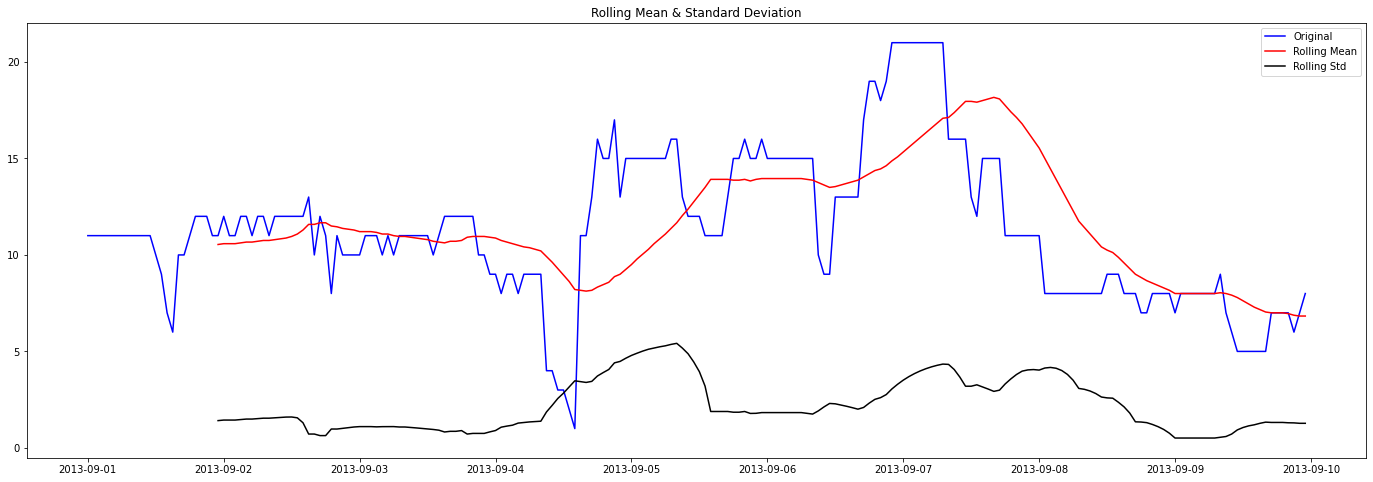

Results of Dickey-Fuller Test:
Test Statistic                  -2.653362
p-value                          0.082462
#Lags Used                       0.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


In [14]:
plt.figure(figsize=(24,8))
test_stationarity(status_v2)

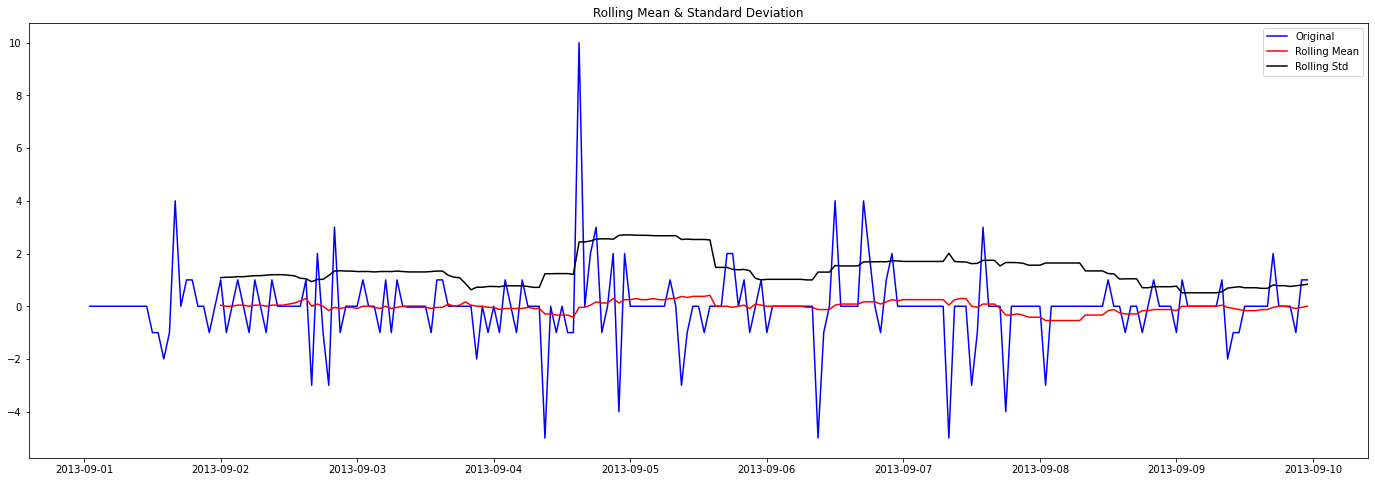

Results of Dickey-Fuller Test:
Test Statistic                -1.556112e+01
p-value                        2.041943e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64


In [17]:
status_v2_diff = status_v2.diff()
plt.figure(figsize=(24,8))
test_stationarity(status_v2_diff.dropna())

In [19]:
status_v2_diff.dropna(inplace = True)
status_v2

date
2013-09-01 00:00:00    11.0
2013-09-01 01:00:00    11.0
2013-09-01 02:00:00    11.0
2013-09-01 03:00:00    11.0
2013-09-01 04:00:00    11.0
                       ... 
2013-09-09 19:00:00     7.0
2013-09-09 20:00:00     7.0
2013-09-09 21:00:00     6.0
2013-09-09 22:00:00     7.0
2013-09-09 23:00:00     8.0
Name: bikes_available, Length: 216, dtype: float64

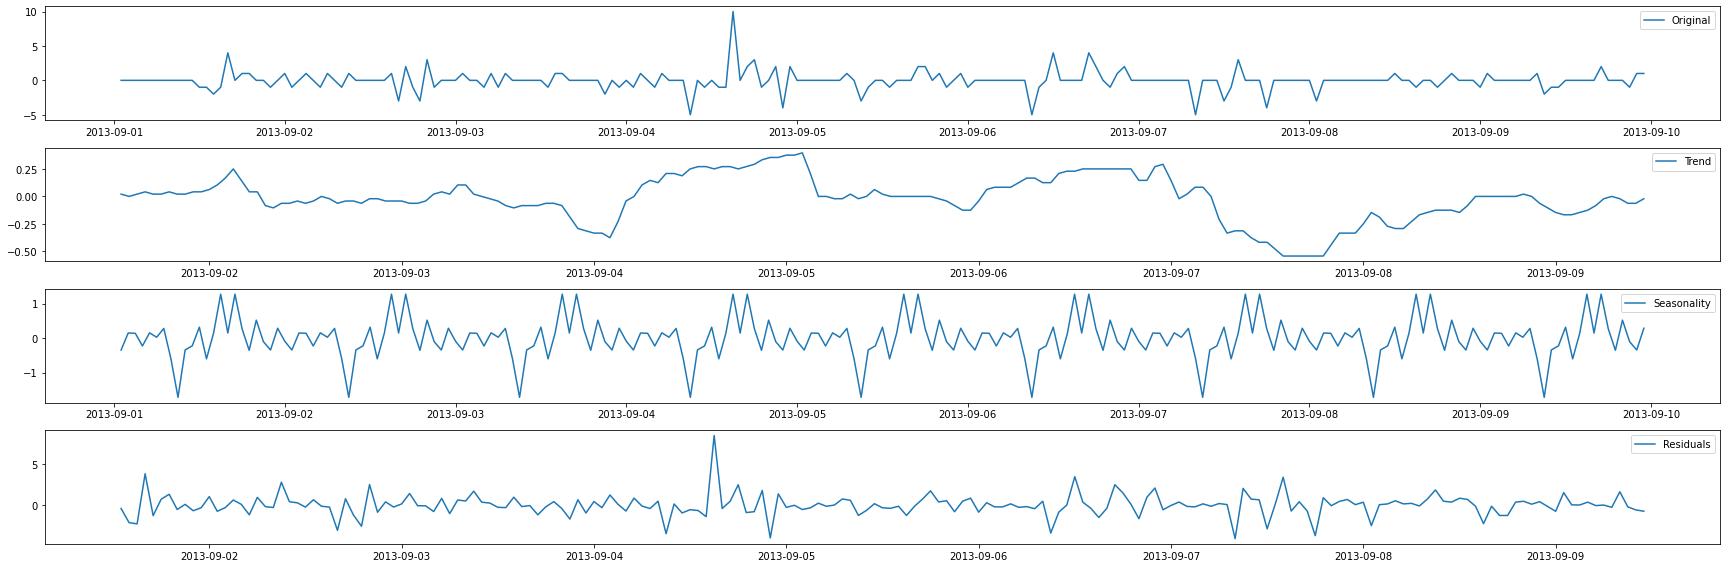

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(status_v2_diff)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(24,8))
plt.subplot(411)
plt.plot(status_v2_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

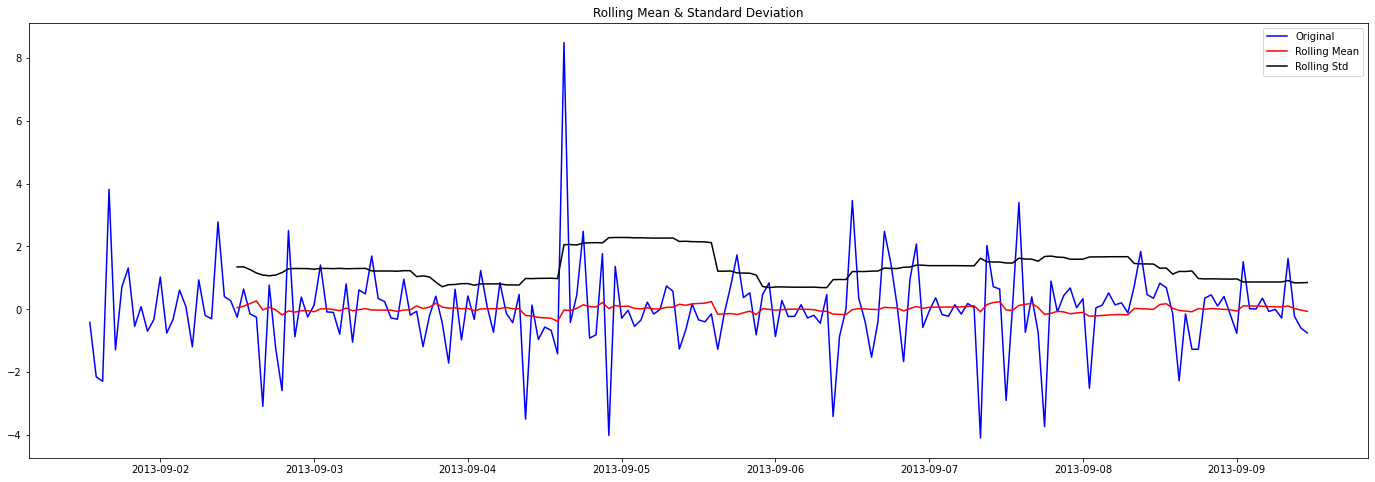

Results of Dickey-Fuller Test:
Test Statistic                -1.609392e+01
p-value                        5.217575e-29
#Lags Used                     0.000000e+00
Number of Observations Used    1.900000e+02
Critical Value (1%)           -3.465244e+00
Critical Value (5%)           -2.876875e+00
Critical Value (10%)          -2.574945e+00
dtype: float64


In [22]:
status_v2_diff_decompose = residual
status_v2_diff_decompose.dropna(inplace=True)
plt.figure(figsize=(24,8))
test_stationarity(status_v2_diff_decompose)

In [24]:
ctt = stattools.adfuller(status_v2, regression="ctt")
ct = stattools.adfuller(status_v2, regression="ct")
c = stattools.adfuller(status_v2, regression="c")
nc = stattools.adfuller(status_v2, regression="nc")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-3.1762178850790255, 0.21838246002853234, 0, 215, {'1%': -4.425837100205014, '5%': -3.8601404739456906, '10%': -3.5704022957978543}, 715.7633367490905)
ct:
(-2.687946436059764, 0.24112133632263533, 0, 215, {'1%': -4.001505932433622, '5%': -3.43111050928849, '10%': -3.1391632091513957}, 715.1988544642121)
c:
(-2.6533615507530532, 0.08246224456018592, 0, 215, {'1%': -3.461136478222043, '5%': -2.875078880098608, '10%': -2.5739861168199027}, 714.4543655284342)
nc:
(-0.9804748726837064, 0.29596090918655105, 0, 215, {'1%': -2.576217533802055, '5%': -1.942318956771102, '10%': -1.6156408118530443}, 719.2244535528322)


In [23]:
ctt = stattools.adfuller(status_v2_diff, regression="ctt")
ct = stattools.adfuller(status_v2_diff, regression="ct")
c = stattools.adfuller(status_v2_diff, regression="c")
nc = stattools.adfuller(status_v2_diff, regression="nc")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-15.497376617777153, 2.845429518941029e-24, 0, 214, {'1%': -4.42609669506703, '5%': -3.860271529587125, '10%': -3.5704829977437527}, 714.331963186501)
ct:
(-15.531776993615418, 1.3636454245977041e-22, 0, 214, {'1%': -4.001708647316869, '5%': -3.4312078274966673, '10%': -3.1392202327591767}, 712.3326273527485)
c:
(-15.561116099146215, 2.0419430748930643e-28, 0, 214, {'1%': -3.4612821203214907, '5%': -2.875142613826617, '10%': -2.574020122281422}, 710.5624038891227)
nc:
(-15.59614444692721, 2.4857647334262687e-27, 0, 214, {'1%': -2.576266862608088, '5%': -1.9423254323113557, '10%': -1.6156355532499675}, 708.571572959189)


C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, Futur

<BarContainer object of 214 artists>

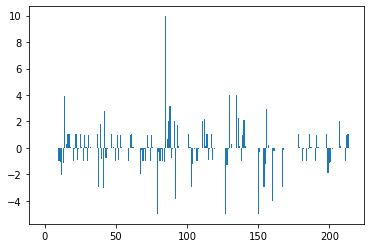

In [25]:
# モデルのあてはめ
model = ar_model.AR(status_v2_diff)
# AICの結果からmaxlag=12としてラグは11
results1 = model.fit(maxlag=20, ic='aic')
# 残差
res1 = results1.resid
# 残差の出力
plt.bar(range(len(res1)), res1)

In [26]:
results1.k_ar

1

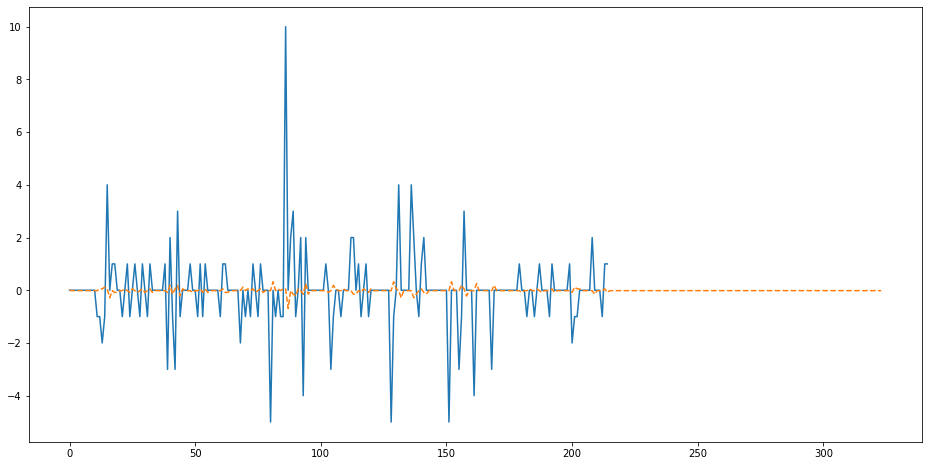

In [27]:
# 将来予測
# 原系列の表示
plt.figure(figsize=(16,8))
plt.plot(status_v2_diff.values, label="observation")
# 1時点から11時点の原系列、モデルの当てはめに使用したデータ、
# AR(11)モデルによる推定値を連結した結果の表示
# np.hstack()はnp.concatenate()でもよい
plt.plot(np.hstack((status_v2_diff[:1], 
                    results1.fittedvalues, 
                    results1.predict(93-1, 200, dynamic=True)
                   )), 
    '--', label="forecast")

In [29]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, s

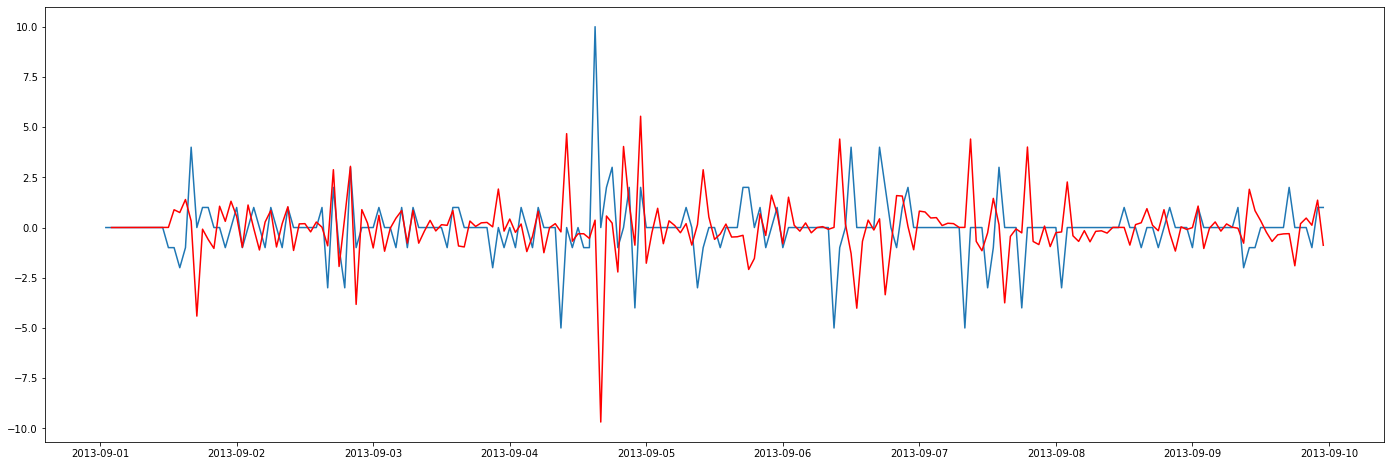

In [30]:
model = ARIMA(status_v2_diff, order=(7, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.figure(figsize=(24,8))
plt.plot(status_v2_diff)
plt.plot(results_AR.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


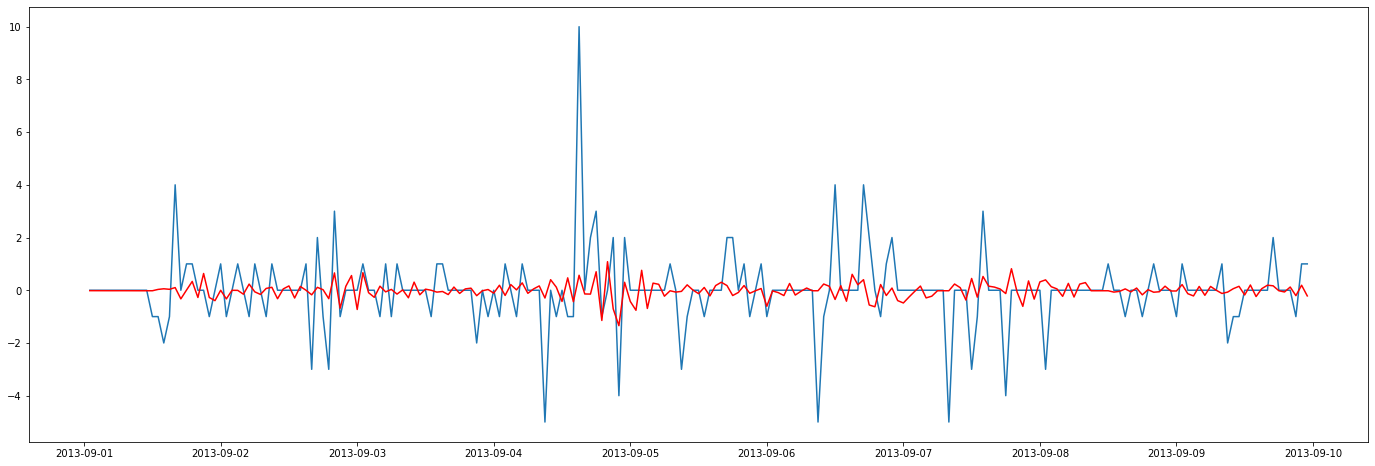

In [63]:
model2 = ARIMA(status_v2, order=(7, 1, 0))  
results_AR2 = model2.fit(disp=-1)  
plt.figure(figsize=(24,8))
plt.plot(status_v2.diff())
plt.plot(results_AR2.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, Futur

<BarContainer object of 215 artists>

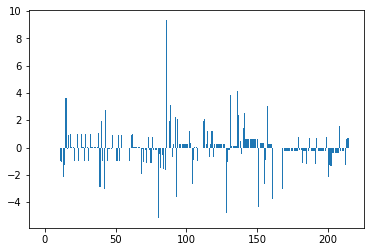

In [60]:
# モデルのあてはめ
model = ar_model.AR(status_v2)
# AICの結果からmaxlag=12としてラグは11
results1 = model.fit(maxlag=20, ic='aic')
# 残差
res1 = results1.resid
# 残差の出力
plt.bar(range(len(res1)), res1)

In [61]:
results1.k_ar

1

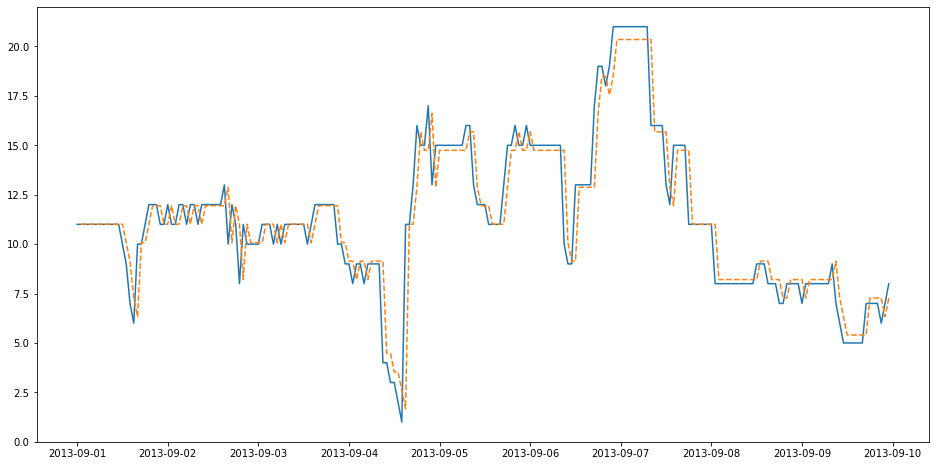

In [62]:
# 将来予測
# 原系列の表示
plt.figure(figsize=(16,8))
plt.plot(status_v2, label="observation")
# 1時点から11時点の原系列、モデルの当てはめに使用したデータ、
# AR(11)モデルによる推定値を連結した結果の表示
# np.hstack()はnp.concatenate()でもよい
plt.plot(results1.fittedvalues, '--', label="forecast")

In [32]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa.arima_model import ARMA

In [31]:
# 次数選択の指標にAICとBICを選択
info_criteria = stattools.arma_order_select_ic(status_v2_diff, ic=['aic', 'bic'])
# AICとBICが最小になる次数をそれぞれ表示
info_criteria.aic_min_order, info_criteria.bic_min_order

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and stat

((3, 2), (0, 0))

In [57]:
# p=4, q=2のARMAモデルのインスタンスを生成
model_ARMA = ARMA(status_v2, (3, 2))
# y_diffに対してモデルを当てはめる
results_ARMA = model_ARMA.fit()
results_ARMA.summary()

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, s

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        bikes_available   No. Observations:                  216
Model:                     ARMA(3, 2)   Log Likelihood                -375.681
Method:                       css-mle   S.D. of innovations              1.371
Date:                Fri, 03 Dec 2021   AIC                            765.361
Time:                        13:31:39   BIC                            788.988
Sample:                    09-01-2013   HQIC                           774.906
                         - 09-09-2013                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.1063      1.342      8.276      0.000       8.476      13.736
ar.L1.bikes_available    -0.4501      0.232     -1.938      0.053      -0.905       0.005
ar.L2.bikes_available     0.6095      0.134      4.535      0.000       0.346       0.873
ar.L3.bikes_available     0.6486      0.169      3.832      0.000       0.317       0.980
ma.L1.bikes_available     1.3481      0.261      5.157      0.000       0.836       1.860
ma.L2.bikes_available     0.5946      0.208      2.863      0.004       0.188       1.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0665           -0.0000j            1.0665           -0.0000
AR.2           -1.0031           -0.6629j            1.2024           -0.4071
AR.3           -1.0031           +0.6629j            1.2024            0.4071
MA.1           -1.1335           -0.6299j            1.2968           -0.4193
MA.2           -1.1335           +0.6299j            1.2968            0.4193
-----------------------------------------------------------------------------
"""

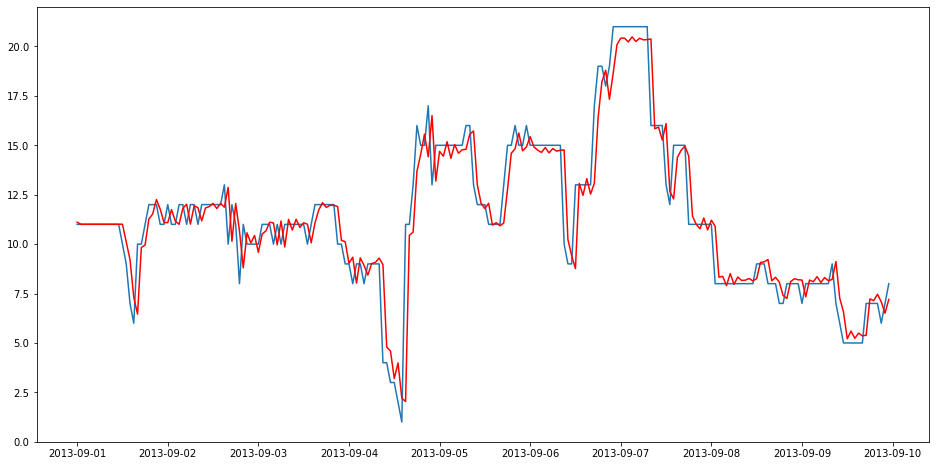

In [58]:
# 1次階差系列の表示
plt.figure(figsize=(16,8))
plt.plot(status_v2, label="observation")
# ARMA(4, 2)による推定値の表示
# np.hstack()はnp.concatenate()でもよい
plt.plot(results_ARMA.fittedvalues, color='red')
#                    results.predict(99-2, 110, dynamic=True)]), 
#         '--', label="forecast")

In [44]:
model_302 = ARIMA(status_v2,order=(3,0,2))
results_302 = model_302.fit()
results_302.summary()

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, s

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        bikes_available   No. Observations:                  216
Model:                     ARMA(3, 2)   Log Likelihood                -375.681
Method:                       css-mle   S.D. of innovations              1.371
Date:                Fri, 03 Dec 2021   AIC                            765.361
Time:                        12:13:19   BIC                            788.988
Sample:                    09-01-2013   HQIC                           774.906
                         - 09-09-2013                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.1063      1.342      8.276      0.000       8.476      13.736
ar.L1.bikes_available    -0.4501      0.232     -1.938      0.053      -0.905       0.005
ar.L2.bikes_available     0.6095      0.134      4.535      0.000       0.346       0.873
ar.L3.bikes_available     0.6486      0.169      3.832      0.000       0.317       0.980
ma.L1.bikes_available     1.3481      0.261      5.157      0.000       0.836       1.860
ma.L2.bikes_available     0.5946      0.208      2.863      0.004       0.188       1.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0665           -0.0000j            1.0665           -0.0000
AR.2           -1.0031           -0.6629j            1.2024           -0.4071
AR.3           -1.0031           +0.6629j            1.2024            0.4071
MA.1           -1.1335           -0.6299j            1.2968           -0.4193
MA.2           -1.1335           +0.6299j            1.2968            0.4193
-----------------------------------------------------------------------------
"""

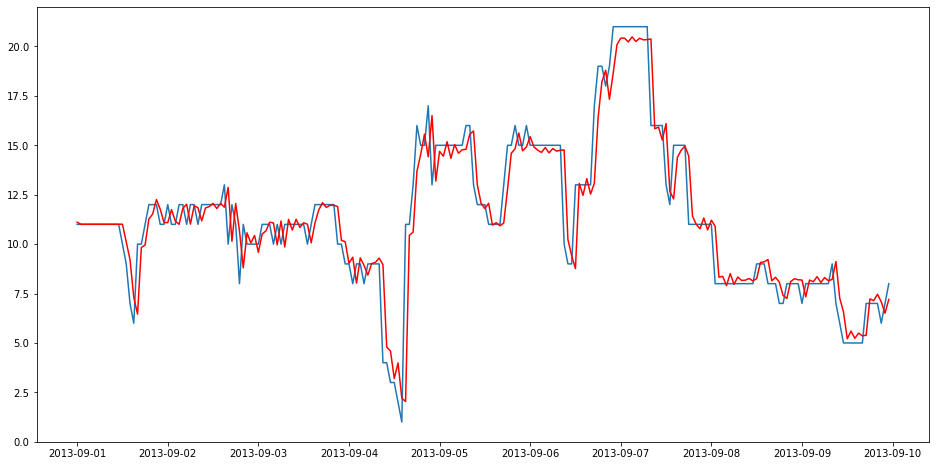

In [45]:
# 将来予測
# トレンドが捉えられていない
# 循環変動も捉えられていない
plt.figure(figsize=(16,8))
# 原系列の表示
plt.plot(status_v2, label='observation')
# インサンプル（学習に使ったサンプルデータ）と
# ARIMA(3, 0, 2)による予測値を含めた系列の表示
# ARモデルの時とpredictの挙動が異なるので要注意
plt.plot(results_302.fittedvalues, color='red')

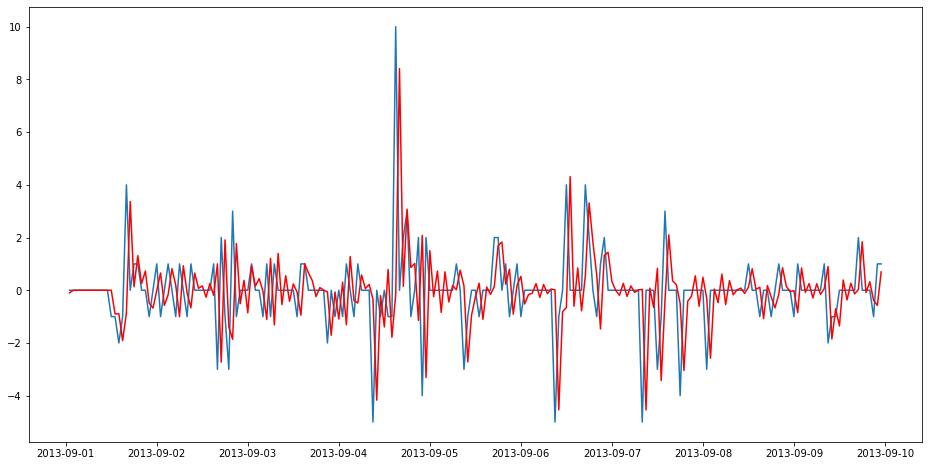

In [53]:
# 将来予測
# トレンドが捉えられていない
# 循環変動も捉えられていない
plt.figure(figsize=(16,8))
# 原系列の表示
plt.plot(status_v2_diff, label='observation')
# インサンプル（学習に使ったサンプルデータ）と
# ARIMA(3, 0, 2)による予測値を含めた系列の表示
# ARモデルの時とpredictの挙動が異なるので要注意
plt.plot(results_302.fittedvalues.diff(), color='red')

In [46]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [48]:
p, d, q, sp, sd, sq = 2, 1, 2, 1, 1, 1
seasonal = 12

# SARIMAX(p=2,d=1,q=2; P=1,D=1,Q=1,s=12)モデルの当てはめ
result = SARIMAX(
    status_v2, order=(p,d,q), 
    seasonal_order=(sp,sd,sq,seasonal), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()
# 結果確認
print(result.summary())

C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\pytho\anaconda3\envs\py-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                       
Dep. Variable:                      bikes_available   No. Observations:                  216
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -347.771
Date:                              Fri, 03 Dec 2021   AIC                            709.543
Time:                                      12:16:01   BIC                            732.198
Sample:                                  09-01-2013   HQIC                           718.722
                                       - 09-09-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1285      0.601     -1.879      0.060      -2.306       0.049
ar.L2         -0.23

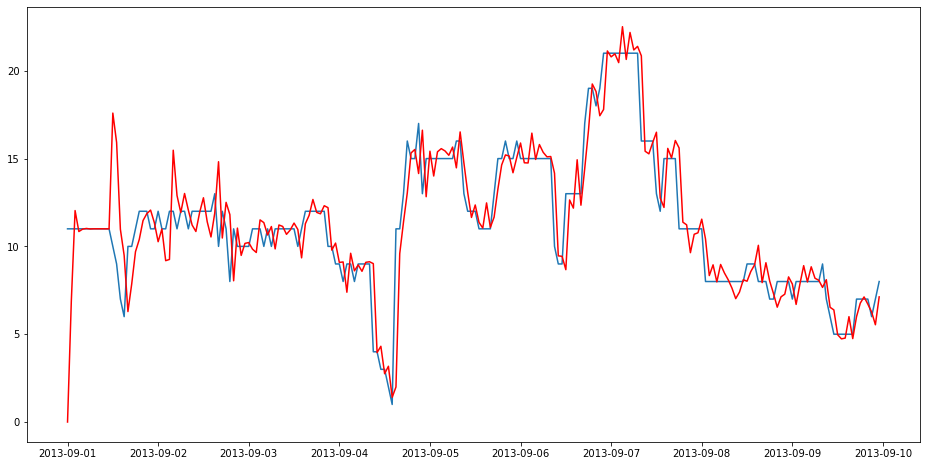

In [52]:
# 将来予測
plt.figure(figsize=(16,8))
plt.plot(status_v2, label="observation")
plt.plot(result.fittedvalues, color='red')

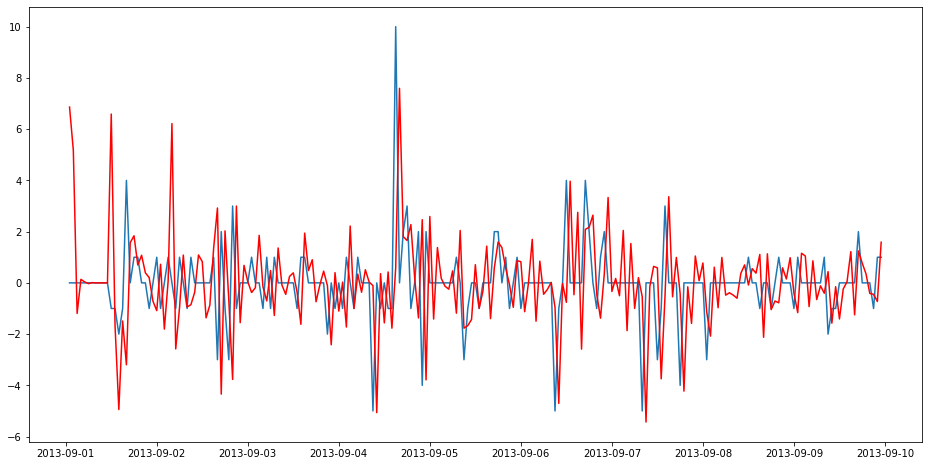

In [54]:
# 将来予測
plt.figure(figsize=(16,8))
plt.plot(status_v2_diff, label="observation")
plt.plot(result.fittedvalues.diff(), color='red')